# Balanced truncation

In [1]:
#use "./init.ml"

In [2]:
open Owl
open Printf
open Noc
open Owl_ode
open Owl_ode.Types

In [3]:
let w = Mat.load_txt "../data/w"
let n, _ = Mat.shape w
let a = Mat.(w - eye n)
let tau = 20E-3
let k = 3 (* number of input and output channels *)

val w : Owl.Mat.mat = ...


val n : int = ...


val a : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val tau : float = ...


val k : int = ...


In [4]:
let simulate ~a ~b ~c input duration =
  let tspec = T1 { t0=0.0; dt=1E-3; duration } in
  let _, n = Mat.shape a in
  let f = 
    let z = Mat.(transpose a /$ tau) in
    fun x t -> 
      let input = Mat.(transpose (b *@ (transpose (input t)))) in
      let dx = Mat.(x *@ z) in
      Mat.(dx + input /$ tau) in
  let ts, xs = Ode.odeint (module Owl_ode.Native.D.RK4) f Mat.(zeros 1 n) tspec () in
  let xs = Mat.(xs *@ transpose c) in
  Mat.concat_horizontal ts xs


val simulate :
  a:Owl.Mat.mat ->
  b:(float, Bigarray.float64_elt) Owl_dense_matrix_generic.t ->
  c:Owl.Mat.mat -> (float -> Owl.Mat.mat) -> float -> Owl.Mat.mat = ...


In [5]:
(* ------- balanced truncation ------ *)
let b = 
  let q = Gramians.obsv a in
  let u, _, _ = Linalg.D.svd q in 
  Mat.get_slice [ []; [0; k-1] ] u

let c = 
  let p = Gramians.ctrl a in
  let u, _, _ = Linalg.D.svd p in 
  Mat.(transpose (get_slice [ []; [0; pred k] ] u))

let p = Gramians.ctrl ~b a
let q = Gramians.obsv ~c a

let s =
  let u, s, _ = Linalg.D.svd p in
  Mat.(transpose (u * sqrt s))

let r =
  let u, s, _ = Linalg.D.svd q in
  Mat.(transpose (u * sqrt s))

let keep = 8

let srt = Mat.(s *@ transpose r)
let u, svals, vt = Linalg.D.svd srt

let hankel_svals = Mat.(transpose svals) 
let hankel_accuracy = 
  let s = svals |> Mat.flip ~axis:1 |> Mat.cumsum ~axis:1 |> Mat.flip ~axis:1 in
  Mat.transpose s

let slice = [0; keep-1]
let u = Mat.get_slice [[]; slice] u
let vt = Mat.get_slice [slice; []] vt
let svals = Mat.get_slice [[]; slice] svals

let t_l = Mat.((transpose (reci (sqrt svals))) * vt *@ r)
let t_r = Mat.(((transpose s) *@ u) * (reci (sqrt svals)))

let a_hat = Mat.(t_l *@ a *@ t_r)
let b_hat = Mat.(t_l *@ b)
let c_hat = Mat.(c *@ t_r)

(* compare truncated system to full system *)
let input, true_xs, reduced_xs = 
  let duration = 1. in
  let input, input_fun = Simulate.ou_process ~n:k ~dt:1E-4 ~tau:20E-3 duration in
  let true_xs = simulate ~a ~b ~c input_fun duration in 
  let reduced_xs = simulate ~a:a_hat ~b:b_hat ~c:c_hat input_fun duration in 
  input, true_xs, reduced_xs

val b : Owl.Mat.mat = ...


val c : Owl.Mat.mat = ...


val p : Owl.Mat.mat = ...


val q : Owl.Mat.mat = ...


val s : Owl.Mat.mat = ...


val r : Owl.Mat.mat = ...


val keep : int = ...


val srt : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val u : Owl.Linalg.D.mat = ...
val svals : Owl.Linalg.D.mat = ...
val vt : Owl.Linalg.D.mat = ...


val hankel_svals : Owl.Mat.mat = ...


val hankel_accuracy : Owl.Mat.mat = ...


val slice : int list = ...


val u : Owl.Mat.mat = ...


val vt : Owl.Mat.mat = ...


val svals : Owl.Mat.mat = ...


val t_l : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val t_r : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val a_hat : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val b_hat : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val c_hat : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val input : Owl.Mat.mat = ...
val true_xs : Owl.Mat.mat = ...
val reduced_xs : Owl.Mat.mat = ...


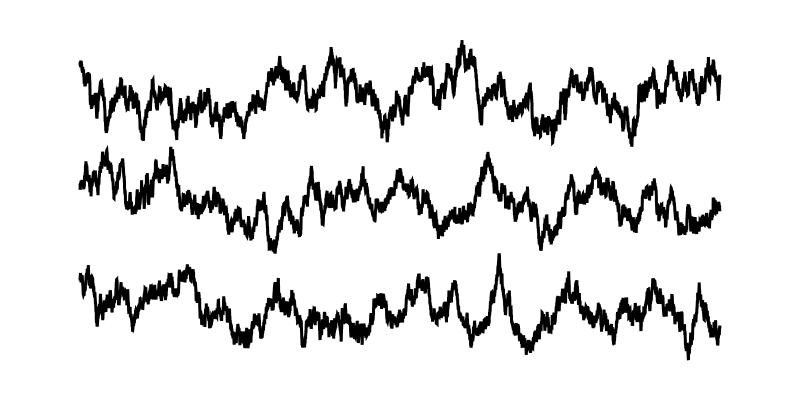

In [6]:
let () =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  let figure (module P: Plot) = 
      P.multiplot ~spacing:(0.05,0.0) (3,1) (fun k row col ->
      P.plot (A input)  ~using:(sprintf "%i" (succ k))  ~style:(sprintf "l lw 3 lc 8") 
      [ barebone ; ]
      ) in
  Juplot.draw ~display_id ~size:(800,400) figure

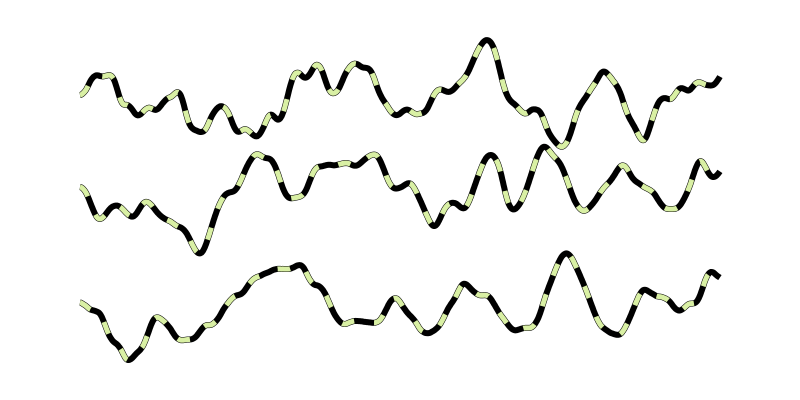

In [7]:
let () =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  let figure (module P: Plot) = 
      P.ex "load 'oranges.pal'";
      P.multiplot ~spacing:(0.05,0.0) (3,1) (fun k row col ->
      P.plots [ 
          item (A true_xs) ~using:(sprintf "1:%i" (k+2)) ~style:"l lc 8 lw 6"; 
          item (A true_xs) ~using:(sprintf "1:%i" (k+2)) ~style:"l lc rgb '#d9f0a4' lw 5 dt 2";
      ]
      [ barebone ; ]
      ) in
  Juplot.draw ~display_id ~size:(800,400) figure